# Simulation and Inference for Neuroscience
## Exercises Week 1: Simulation

The notebook below contains the exercises for week 1.
The exercises are designed to follow the lecture material and do not need deep knowledge of python to be solved.

There are two types of exercises:
- **Tasks**: Where you need to write code, i.e. "implement a function that does X".
- **Questions**: Where you need to answer questions using the code you wrote. For example "vary the inputs and interpret the results", will require you to provide one or more plots together with your answer. To answer the questions you can use Markdown cells.

All necessary dependencies are imported in the first cell and you should not need to import anything else. In addition, we also provide some helper functions that can be used to help you answering the tasks. When solving the tasks, feel free to change the provided function signatures and code as you see fit. However, we recommend sticking with the provided signatures as they reflect common conventions and will make it easier to add additional functionality during the exercise. Type hints are provided for the function signatures and the arguments and each task should only require a few lines of code.

In [1]:
# dependencies
import numpy as np
import matplotlib.pyplot as plt
from math import pi

import jaxley as jx
from jaxley.channels import HH
import jax.numpy as jnp

from typing import Callable, Tuple, Dict

In [2]:
# utils
def step_current(amp: float, t0: float, t1: float) -> Callable[[float], float]:
    """Return step current  I(t) = amp * (t0 <= t) * (t <= t1)"""
    def current(t):
        return amp * (t0 <= t) * (t <= t1)
    return current

def area(r: float, l: float) -> float: 
    """Return the surface area of a cylinder with radius r and length l."""
    return 2.0 * pi * r * l # μm²

def plot_voltage(t: np.ndarray, v: np.ndarray, ax: plt.Axes = None) -> plt.Axes:
    """Plot the voltage v(t)."""
    if ax is None:
        ax = plt.gca()
    ax.plot(t, v)
    ax.set_xlabel("t (ms)")
    ax.set_ylabel("V (mV)")
    return ax

def plot_stimulus(t: np.ndarray, ipt: Callable[[float], float], ax: plt.Axes = None) -> plt.Axes:
    """Plot the stimulus I(t)."""
    if ax is None:
        ax = plt.gca()
    ax.plot(t, ipt(t))
    ax.set_xlabel("t (ms)")
    ax.set_ylabel("I (nA)")
    return ax

def make_plot(t: np.ndarray, u: np.ndarray, ipt: Callable[[float], float]) -> Tuple[plt.Figure, plt.Axes]:
    """Plot voltage and stimulus"""
    plot_spec = {"sharex": True, "gridspec_kw": {"height_ratios": [3, 1]}, "layout": "constrained"}
    fig, axs = plt.subplots(2, 1, figsize=(6, 3), **plot_spec)

    plot_voltage(t, u[:, :, 0], axs[0])
    plot_stimulus(t, ipt, axs[1])
    axs[0].set_xlabel("")
    return axs


# Numerical integration
Biophsical neuron models can be described by a system of ODEs. This means in order to simulate such as system, we need to solve an [initial value problem](https://en.wikipedia.org/wiki/Initial_value_problem) of the form 

$$
\frac{du}{dt} = f(t, u, p)
$$

with states $u$, parameters $p$ and initial condition $u(t_0) = u_0$. Since the dynamics of biophysical models are typically non-linear however, we can only approximate the solution using numerical methods. This means we need to discretize the time into small steps and then use an ODE solver to approximate the solution in an iterative fashion.

Here is a general outline of such an integration loop:

$$
\begin{align*}
&\text{Input:} \quad f(t,u,p), \, t_0, \, t_1, \, u_0, \, p, \, dt, \, \text{solver} \\
&\text{Initialize:} \\
&\quad t[i] = t_0 + i\cdot dt \quad \text{for} \quad i = 0,\ldots,N-1 \quad \text{where} \quad N = \lceil(t_1-t_0)/dt\rceil \\
&\quad u[0] = u_0 \\
&\text{For } i = 0 \text{ to } N-1: \\
&\quad u[i+1] = \text{solver}(f, t[i], u[i], p, dt) \\
&\text{Output:} \quad t[0:N], \, u[0:N]
\end{align*}
$$


# Forward Euler

One of the simplest solvers is the [Forward Euler method](https://en.wikipedia.org/wiki/Euler_method). Let's try to implement an integration loop using the Forward Euler method in the following cell.

### Tasks
- implement the forward euler method
- implement the integration loop

_Note: You can test your implementation by running the `test_fw_euler` and `test_integrate` functions._

In [25]:
def fw_euler(f: Callable[[float, np.ndarray, Tuple], np.ndarray], t: float, u: np.ndarray, args: Tuple, dt: float) -> np.ndarray:
    """One step of the Forward Euler method.

    Args:
        f: The function/vector field to integrate. `du/dt = f(t, u, args)`.
        t: The current time.
        u: The current state, `u[i]`, (num_comps, num_states).
        args: Additional arguments to f.
        dt: The time step.

    Returns:
        The next state, `u[i+1]`, (num_comps, num_states).
    """
    # add your code here
    u = u + dt * f(t,u,args)
    return u

def integrate(f: Callable[[float, np.ndarray, Tuple], np.ndarray], solver: Callable, tspan: Tuple[float, float], u0: np.ndarray, args: Tuple, dt: float) -> Tuple[np.ndarray, np.ndarray]:
    """Integrate the function/vector field using a given solver.

    Args:
        f: The function/vector field to integrate.
        solver: The solver to use, i.e. `fw_euler`.
        tspan: The time span to integrate over, (t0, t1).
        u0: The initial state, (num_comps, num_states).
        args: Additional arguments to vf.
        dt: The step size.
    
    Returns:
        t: The time points.
        u: The state at the time points, (num_steps, num_comps, num_states).
    """
    
    # add your code here
    t0,t1 = tspan
    N = np.ceil((t1-t0)/dt)
    T = np.arange(t0,t1,dt)
    u = u0
    output = []
    for t in T:
        u = solver(f , t,u,args,dt )
        output.append(u)
    u = np.array(output)
    return T, u

In [26]:
f_test = lambda t, u, args: u # du = u
u0 = np.array([[1.0]])

def test_fw_euler():
    u_next = fw_euler(f_test, 0.0, u0, args = (), dt = 0.1)
    assert np.allclose(u_next, 1.1), "u_next should be 1.1"
    assert u_next.shape == (1,1), "u_next should be a 1x1 array"
    print("`fw_euler` passed")

def test_integrate():
    t, u = integrate(f_test, fw_euler, tspan=(0, 1), u0=u0, args=(), dt=0.01)
    assert np.allclose(u.flatten(), np.exp(t), atol=1e-1), "u should be close to exp(t)"
    assert u.shape == (100, 1, 1), "u should be of shape (100, 1, 1)"
    assert t.shape == (100,), "t should be of shape (100,)"
    print("`integrate` passed")

test_fw_euler()
test_integrate()

`fw_euler` passed
`integrate` passed


# Basic membrane dynamics

In order to check if the numerical integration works, let's start by simulating a piece / section of membrane reacting to a step current input. We can model a piece of membrane as a capacitor $C$ in series with a resistor $R=1/g$, which is driven by an external current $I_{ext}$ (in $\mu A/cm^2$).

$$
C \frac{dV}{dt} = I_{ext} - g V
$$

We will use a step current such as $I(t) = I_{amp} \cdot \mathbb{1}(t_{start} \leq t \leq t_{end})$ (in $nA$) and assume the a cylindrical section with radius $r=1\mu m$, length $l=10\mu m$, membrane capacitance $C=1\mu F/cm^2$ and membrane conductance $g=0.001 mS/cm^2$. 

Note:
- Make sure the equation is consistent with the form that the solver expects. 
- Not all solver arguments have to be used inside the function.
- Be careful with the units of $I(t)$, $I_{ext}$ (!), $g$ and $V$.


### Tasks
- implement a basic membrane model
- integrate the model
- plot the results (you can use the `make_plot` function to plot the results)

In [35]:
def membrane(t: float, u: np.ndarray, args: Tuple) -> np.ndarray:
    """Basic membrane dynamics.

    Args:
        t: The current time.
        u: The current state.
        args: Additional arguments, i.e. `p` and `ipt`.

    Returns:
        du: The derivative of the state.
    """
    p, ipt = args
    v = u
    l = p['l']
    r = p['r']
    c = p['c']
    area = 2*pi*r*l
    I = 10**5 * ipt(t)/area
    gv = p['g'] * v * 1000
    du = (I-gv)/c
    # add your code here    
    return du

v0 = np.array([[0.0]])
dt = 0.025
stimulus = step_current(0.001, 10, 90)
params = {"c": 1.0, "g": 0.001, "r": 1.0, "l": 10.0}
t, v = integrate(membrane, fw_euler,(0, 100), v0, (params, stimulus), dt)

array([<Axes: ylabel='V (mV)'>, <Axes: xlabel='t (ms)', ylabel='I (nA)'>],
      dtype=object)

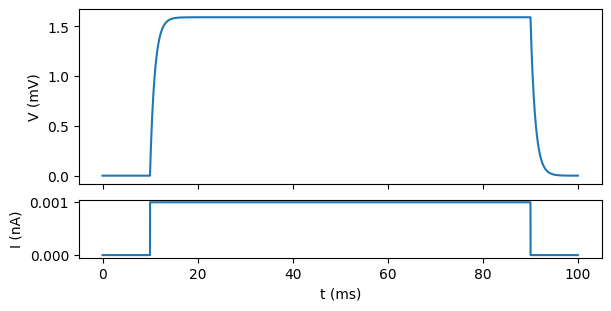

In [36]:
# plot the results
make_plot(t,v,stimulus)

# Leak current

Now that you know how to simulate a section of membrane, let's increase the complexity of our model slightly by modelling the movement of ions rather than of arbitrary charges. To do this we also need to account for the diffusion forces that drive the movement of ions across the membrane. These diffusion forces lead to a non-zero equilibrium potential at which there is no net leakage of ions through the membrane. In the following we assume an equilibrium potential of $E_{leak} = -70 mV$.

$$
I_{leak} = \bar{g}_{leak} (V - E_{leak})
$$

$$
C \frac{dV}{dt} = I_{ext} - I_{leak}
$$

### Tasks
- implement a leak current
- integrate the model
- plot the results

### Questions
- What is the effect of adding $E_{leak}$?
- How do the different parameters influence the dynamics?
- What effect do different stimuli have?

In [37]:
def leak(t: float, u: np.ndarray, args: Tuple) -> np.ndarray:
    """Leak current.

    Args:
        t: The current time.
        u: The current state.
        args: Additional arguments, i.e. `p` and `ipt`.

    Returns:
        du: The derivative of the state.
    """

    p, ipt = args
    v = u
    l = p['l']
    r = p['r']
    c = p['c']
    e = p['e']
    area = 2*pi*r*l
    I = 10**5 * ipt(t)/area
    I_leak = p['g'] * (v-e) * 1000
    du = (I-I_leak)/c
    return du    # add your code here
 

In [38]:
params = {"c": 1.0, "g": 0.001, "e": -70.0, "r": 1.0, "l": 10.0}

v0 = np.array([[-70.0]])
dt = 0.025
stimulus = step_current(0.01, 10, 90)
t, v = integrate(leak, fw_euler, (0, 100), v0, (params, stimulus), dt)

array([<Axes: ylabel='V (mV)'>, <Axes: xlabel='t (ms)', ylabel='I (nA)'>],
      dtype=object)

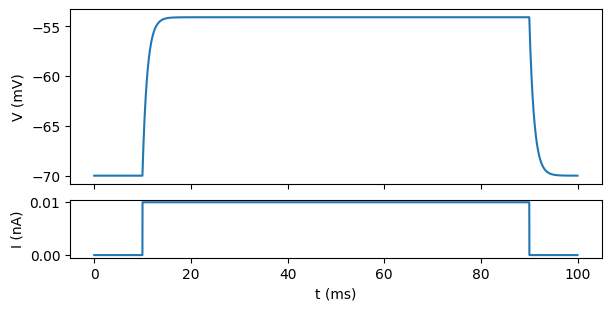

In [39]:
# plot the results and answer the questions
make_plot(t,v,stimulus)

# Hodgkin-Huxley model
We now have a model of how ions leak across the membrane. However, this is not enough to produce any spiking activity yet. To do this we need to add active mechanisms that can produce action potentials. In the simplest case we can consider a spike to be a discrete event that happens when the membrane potential $V$ reaches a certain threshold, which is the basic idea of a [Leaky Integrate and Fire (LIF) model](https://en.wikipedia.org/wiki/Leaky_integrate_and_fire_model). A more accurate description of the membrane potential dynamics can be obtained by modelling the flow of different ions through specific voltage dependent channels in the membrane. This is the basic idea of the [Hodgkin-Huxley model](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model). 

Let's implement a basic version of this model by adding a sodium and a potassium current to the membrane.

$$
I_{Na} = \bar{g}_{Na} m^3 h (V - E_{Na})\\
I_{K} = \bar{g}_{K} n^4 (V - E_{K})\\
I_{leak} = \bar{g}_{leak} (V - E_{leak})
$$

$$
C \frac{dV}{dt} = I_{ext} - I_{leak} - I_{Na} - I_{K}
$$


While $I_{leak}$ is an entirely passive current ($g_{leak} = \bar{g}_{leak}$), this is not the case for $I_{Na}$ and $I_{K}$. Here, the conductance of the ion channels depends on the membrane voltage. These channel dynamics are modelled via a set of gating variables $m(V)$, $h(V)$ and $n(V)$, which all adhere to the following general equation: 
$$
\frac{dx}{dt} = \alpha_x(V) (1 - x) - \beta_x(V) x,
$$
where $x$ is the gating variable, $V$ is the membrane voltage and $\alpha_x(V)$ and $\beta_x(V)$ are rate functions, that describe how the gates open and close as a function of voltage. For the sodium and potassium channels we will use the rate functions below:

$$
\begin{align*}
\alpha_m(V) &= 0.1 \frac{-(V + 40)}{\exp(-(V + 40)/10) - 1}\\
\beta_m(V) &= 4.0 \exp(-(V + 65)/18)\\
\end{align*}
$$

$$
\begin{align*}
\alpha_h(V) &= 0.07 \exp(-(V + 65)/20)\\
\beta_h(V) &= 1.0 / (1 + \exp(-(V + 35)/10))\\
\end{align*}
$$

$$
\begin{align*}
\alpha_n(V) &= 0.01 \frac{-(V + 55)}{\exp(-(V + 55)/10) - 1}\\
\beta_n(V) &= 0.125 \exp(-(V + 65)/80)
\end{align*}
$$


### Tasks
- implement the different currents and gates
- implement a single compartment HH model
- integrate the model
- plot the results

_Hint: Before you start implementing the HH model, think about what variables should make up the state vector `u` and what the initial conditions should be._

### Questions
- How does the model behave when the parameters are changed?
- What is the effect of the different currents?
- How do the gates behave?
- How does the spiking behavior change with different input currents?
- What is the effect of different step sizes? Are there trade-offs?

In [ ]:
def _vtrap(x: float, y: float) -> float: return x / (np.exp(x/y) - 1.0)
def taux(v: float, a: Callable, b: Callable) -> float: return 1 / (a(v) + b(v))
def xinf(v: float, a: Callable, b: Callable) -> float: return a(v) * taux(v, a, b)

def a_m(v: float) -> float: return 0.1 * _vtrap(-(v + 40), 10)
def b_m(v: float) -> float: return 4.0 * np.exp(-(v + 65) / 18)
def a_h(v: float) -> float: return 0.07 * np.exp(-(v + 65) / 20)
def b_h(v: float) -> float: return 1.0 / (np.exp(-(v + 35) / 10) + 1)
def a_n(v: float) -> float: return 0.01 * _vtrap(-(v + 55), 10)
def b_n(v: float) -> float: return 0.125 * np.exp(-(v + 65) / 80)

def compartment(t: float, u: np.ndarray, args: Tuple) -> np.ndarray: 
    """HH model for a single compartment.

    Args:
        t: The current time.
        u: The current state.
        args: Additional arguments, i.e. `p` and `ipt`.

    Returns:
        du: The derivative of the state.
    """
    # unpack the state and args
    p, ipt = args
    v = u
    v0 = v[0][0]
    
    l = p['l']
    r = p['r']
    c = p['c']
    area = 2*pi*r*l
    I_ext = 10**5 * ipt(t)/area
    
    # leak stuff
    leak = p["leak"]
    I_leak = leak['g'] * (v-leak['e']) * 1000
    
    
    # NA stuff
    na = p['na']
    m  = a_m(v0)
    h  = b_h(v0)

    
    I_na = na['g'] * m**3 * h* (v-na['e'])*1000 
    
    # K stuff
    k_ = p['k']
    n = a_n(v0)
    I_k = k_['g'] * n**4 * (v-k_['e'])*1000 
    
    
    # # implement the ionic currents
    # i_leak = # add your code here
    # i_na = # add your code here
    # i_k = # add your code here

    # # implement the gating variables
    dm = a_m(v0) # add your code here
    dh = a_h(v0) # add your code here
    dn = a_n(v0) # add your code here

    # implement the derivative of the membrane voltage
    dv = (I_ext - I_leak - I_k - I_na)/c

    return  dv # derivative of the state

In [53]:
params = {"leak": {"g": 0.0003, "e": -54.3}, "na": {"g": 0.12, "e": 50.0}, "k": {"g": 0.036, "e": -77.0}, "c": 1.0, "l": 10.0, "r": 1.0}

dt = 0.025
v0 = -65.0
vk0 = 50.0
vn0 = -70.0
stimulus = step_current(0.01, 10, 90)
u0 = np.array([[v0,vn0,vk0]]) # add the initial conditions here
t, u = integrate(compartment, fw_euler, (0, 100), u0, (params, stimulus), dt)

/tmp/ipykernel_10796/1461181533.py:44: RuntimeWarning: overflow encountered in multiply
  I_na = na['g'] * m**3 *h * (v-na['e']) * 1000
/tmp/ipykernel_10796/1854052970.py:15: RuntimeWarning: invalid value encountered in add
  u = u + dt * f(t,u,args)


array([<Axes: ylabel='V (mV)'>, <Axes: xlabel='t (ms)', ylabel='I (nA)'>],
      dtype=object)

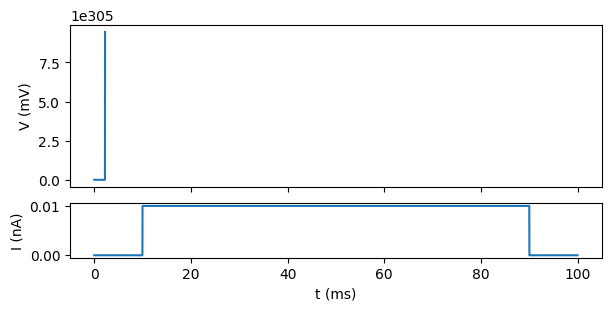

In [54]:
# plot the results and answer the questions
make_plot(t,u,stimulus)

# Multi-compartment models
So far the biophysical models we have built have assumed the neuron to be a single spherical or cylindrical compartment. This can already capture a lot of the dynamics of the neuron, but in practice neurons have very complicated branched structures, which lead to spatially extended dynamics that single compartment models are not able to capture. Hence, in order to resolve these dynamics more accurately we need to increase the spatial resolution of our model.

This is what [Multi-compartment models](https://en.wikipedia.org/wiki/Compartmental_neuron_models) aim to do. By increasing the number of compartments that are used to model a single neuron and connecting them up in series or parallel they can better account for the branched morphology of the neuron. 
TODO: Add picture.

# Cable
In order to turn the single compartment model we have implemented into a multi-compartment model we need to account for the contribution of neighbouring compartments to the membrane potential of a given compartment. For a cable this is relatively simple as we can assume that the current flowing into a compartment from a neighbouring compartment is proportional to the voltage difference between the two compartments. This means that the dynamics of a cable can be described by the following equation:

$$
C_i \frac{dV_i}{dt} = I_{ext, i} - I_{ion, i} + \sum_{j=1}^{N} g_{ij} (V_j - V_i),
$$

where $g_{ij}$ is the conductance between compartment $i$ and $j$ ($g_{ij} = 0$ if $i$ and $j$ are not electrically coupled).


### Tasks
- Write down the equation above for the specific case of a cable.
- Implement $g_{ij}$ (see [here](https://en.wikipedia.org/wiki/Compartmental_neuron_models)).
- Simulate the response of a 4 compartment cable to a step current input in the first compartment.
- Plot the results.

_Note, that you can reuse the HH model from the previous section when implementing the cable._

### Questions
- Can you compute the travel time of an AP across the cable?
- How does it change with
 - myelination
 - the coupling strength
 - the diameter of the cable
- What can you observe if you stimulate multiple compartments?

In [283]:
def g_ij(p_i: Dict, p_j: Dict) -> float:
    """
    from `https://en.wikipedia.org/wiki/Compartmental_neuron_models`.
    `radius`: um, `Ra`: ohm cm, `l`: um, `g`: mS / cm^2
    """
    r_i, Ra_i, l_i = p_i["r"], p_i["Ra"], p_i["l"]
    r_j, Ra_j, l_j = p_j["r"], p_j["Ra"], p_j["l"]
    g = # add your code for g_ij here
    return g * 10**7 # S/cm/um -> mS / cm²

def cable(t: float, u: np.ndarray, args: Tuple) -> np.ndarray:
    """Cable model.

    Connects a number of compartments in series.

    c*dv_i/dt = i_ext_i - i_ion_i + sum_{j=1}^{N} g_ij (v_j - v_i)

    Args:
        t: The current time.
        u: The current state, (num_comps, num_states).
        args: Additional arguments, i.e. `p` and `ipt`.

    Returns:
        du: The derivative of the state for each compartment, (num_comps, num_states).
    """
    # unpack args
    
    # create a connectivity matrix for the cable
    G = # add your code here
    
    du = []
    for u_i, p_i, ipt_i in zip(u, p, ipt):
        # compute the derivative of the membrane voltage for each compartment

    for (i,j) in zip(*np.where(G)):
        # add the contribution of the coupling current to the derivative of the membrane voltage
    return du

In [267]:
params = (
{"leak": {"g": 0.0003, "e": -54.3}, "na": {"g": 0.12, "e": 50.0}, "k": {"g": 0.036, "e": -77.0}, "c": 1.0, "l": 100.0, "r": 1.0, "Ra": 5000},
{"leak": {"g": 0.0003, "e": -54.3}, "na": {"g": 0.12, "e": 50.0}, "k": {"g": 0.036, "e": -77.0}, "c": 1.0, "l": 100.0, "r": 1.0, "Ra": 5000},
{"leak": {"g": 0.0003, "e": -54.3}, "na": {"g": 0.12, "e": 50.0}, "k": {"g": 0.036, "e": -77.0}, "c": 1.0, "l": 100.0, "r": 1.0, "Ra": 5000},
{"leak": {"g": 0.0003, "e": -54.3}, "na": {"g": 0.12, "e": 50.0}, "k": {"g": 0.036, "e": -77.0}, "c": 1.0, "l": 100.0, "r": 1.0, "Ra": 5000},
)

dt = 0.025
v0 = -65.0
# we only stimulate the first compartment
stimuli = (step_current(0.1, 10, 90), step_current(0.00, 10, 90), step_current(0.0, 10, 90), step_current(0.0, 10, 90))

# add the initial conditions for each compartment here
u0 = np.array([
(v0, ), 
(v0, ),
(v0, ),
(v0, ),
])

t, u = integrate(cable, fw_euler, (0, 100), u0, (params, stimuli), dt)

In [ ]:
# plot the results and answer the questions

# Bonus: Accelerate your simulation using jax
So far we have relied on [numpy](https://numpy.org/) to implement and integrate our models. While numpy is plenty fast for most applications, there are a few drawbacks:
- numpy does not support GPU acceleration
- numpy does not support automatic differentiation
- for-loops are slow

One library that aims to address these issues is [jax](https://jax.readthedocs.io/en/latest/). Jax is a library for high-performance numerical computing with automatic differentiation. What makes it particularly useful for simulating biophysical models are the following features:
- Jax natively runs on GPUs (great for large multi-compartment models)
- Jax supports automatic differentiation (important for fitting models using gradient descent)
- Jax offers just-in-time compilation (speeds up integration loops by several orders of magnitude)

The simplest way to benefit from jax is to use [`jax.numpy`](https://jax.readthedocs.io/en/latest/jax.numpy.html) as a drop in replacement for anything you did with `numpy` before. Without any additional changes this allows your code to run on a GPU if you have one available or to obtain gradients.

Another way to gain performance is by using [`vmap`](https://jax.readthedocs.io/en/latest/jax.vmap.html) to vectorize your integration loop. This allows jax to automatically parallelize the integration loop over the different compartments.

In addition functions that get repeatedly called, like inside the integration loop, can be compiled using [`jax.jit`](https://jax.readthedocs.io/en/latest/jax.jit.html). This makes calls to the function (after it has been compiled) significantly faster, often by a factor of 100 or more. You can get even more performance out of jax by using the [`lax`](https://jax.readthedocs.io/en/latest/jax.lax.html) module, which offers a set of functions that are specifically designed to be fast, i.e. a fast `for`-loop alternative called [`lax.scan`](https://jax.readthedocs.io/en/latest/jax.lax.html#jax.lax.scan).


### Tasks
- reimplement your multi-compartment HH model using jax
- reimplement your forward euler integration loop using jax
- accelerate it using jit and `lax.scan`.
- compare the performance of the jax and numpy models

_Note: To solve this task you will need to import additional dependencies, i.e. `import jax.numpy as jnp`, that were not loaded in the first cell._

In [ ]:
# ...

# Implement a cable in jaxley
Now that you have implemented a mutli compartment HH model from scratch and possibly used jax to accelerate it, let's see how easy it is to implement a multi-compartment model using the [`jaxley`](https://jaxley.readthedocs.io/en/latest/) library. 

Jaxley is a differentiable simulator for biophysical neuron models in `JAX` which (among other things) supports:
- automatic differentiation, allowing gradient-based optimization of thousands of parameters
- acceleration on CPU, GPU, or TPU without any changes to the code
- jit-compilation, making it as fast as other packages while being fully written in python
- backward-Euler solvers for stable numerical solution of multicompartment neurons

Using the tutorials on the [jaxley website](https://jaxley.readthedocs.io/en/latest/tutorials.html), implement a cable in jaxley and recreate the simulation from the previous section.

### Tasks
- implement a cable in jaxley
- simulate the cable to a step current input in the first compartment
- plot the results

### Questions
- How does the simulation time compare to the numpy implementation?

In [ ]:
dt = 0.025
stimulus = step_current(0.1, 10, 90)
ts = np.arange(0, 100, dt)
v0 = -65.0
# each compartment should be 100 um long and have HH dynamics and only the first compartment should be stimulated
# Note that the stimulus needs to be supplied as an array

# Don't forget to initialize the model appropriately

In [ ]:
# plot the results